Multi class semantic (2D) segmentation using Unet architecture.

Importing the necessary libraries.

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

Downloading the Crowd Instance-level Human Parsing Dataset.

In [ ]:
!gdown "1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:30<00:00, 97.0MB/s]


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 200

# the dataset contains a huge number of images, I am just going to use a sample.
train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>


In [ ]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [ ]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [ ]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
# no of classes
OUTPUT_CHANNELS = 20

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(512, 512,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

with strategy.scope():
# instantiate the model
  model = unet()

  # see the resulting model architecture
  model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_103 (Conv2D)            (None, 512, 512, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 activation_62 (Activation)     (None, 512, 512, 64  0           ['conv2d_103[0][0]']             
                                )                                                           

In [ ]:
with strategy.scope():
# configure the optimizer, loss and metrics for training
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
with strategy.scope():
  history = model.fit(train_dataset, validation_data=val_dataset, epochs=45)

Epoch 1/45
125/125 [==============================] - 347s 3s/step - loss: 6.9206 - accuracy: 0.5162 - val_loss: 1.6118 - val_accuracy: 0.6008
Epoch 2/45
125/125 [==============================] - 310s 2s/step - loss: 1.6743 - accuracy: 0.5656 - val_loss: 1.5020 - val_accuracy: 0.6022
Epoch 3/45
125/125 [==============================] - 310s 2s/step - loss: 1.5950 - accuracy: 0.5683 - val_loss: 1.4616 - val_accuracy: 0.6119
Epoch 4/45
125/125 [==============================] - 310s 2s/step - loss: 1.5578 - accuracy: 0.5728 - val_loss: 1.4271 - val_accuracy: 0.6135
Epoch 5/45
125/125 [==============================] - 309s 2s/step - loss: 1.5298 - accuracy: 0.5744 - val_loss: 1.3980 - val_accuracy: 0.6153
Epoch 6/45
125/125 [==============================] - 309s 2s/step - loss: 1.5133 - accuracy: 0.5753 - val_loss: 1.3907 - val_accuracy: 0.6157
Epoch 7/45
125/125 [==============================] - 309s 2s/step - loss: 1.5037 - accuracy: 0.5754 - val_loss: 1.3936 - val_accuracy: 0.6131

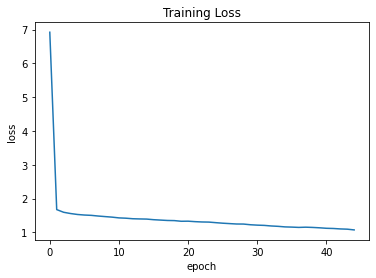

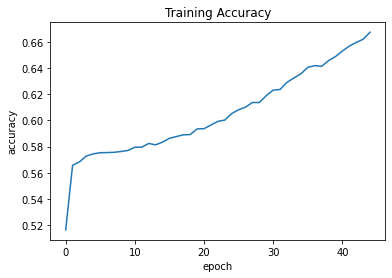

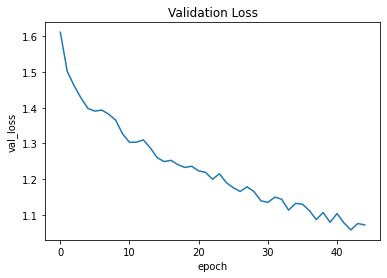

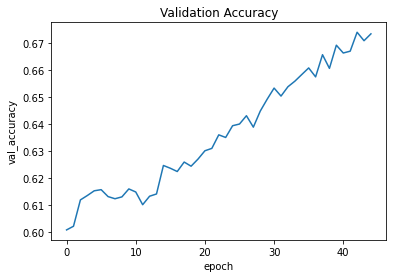

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
# Loading the Colormap
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )


1/1 [==============================] - 5s 5s/step


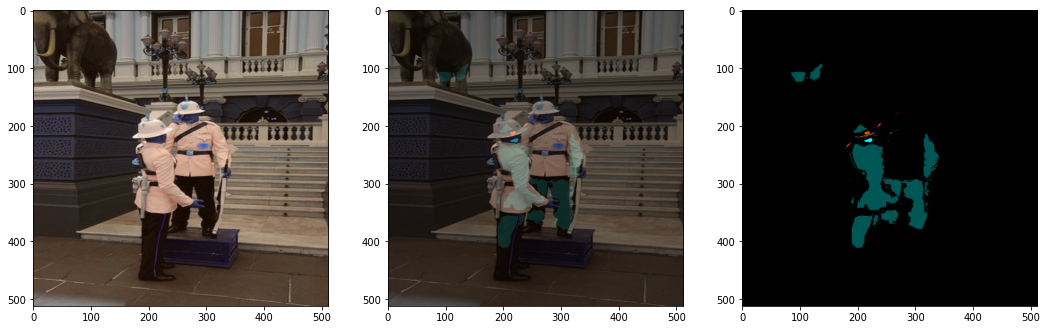

1/1 [==============================] - 0s 71ms/step


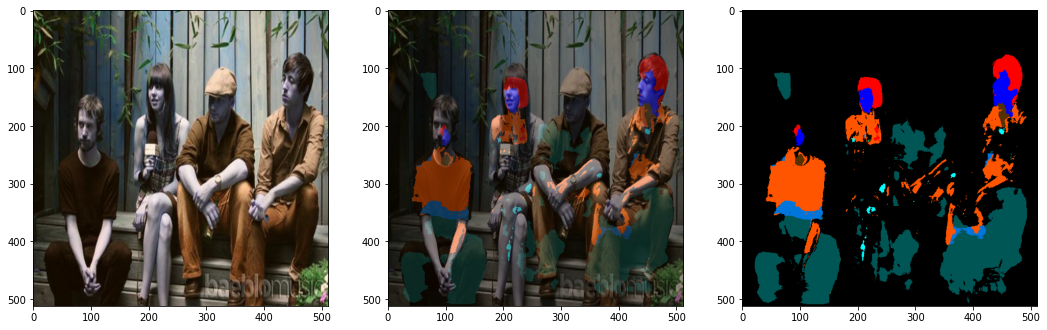

1/1 [==============================] - 0s 70ms/step


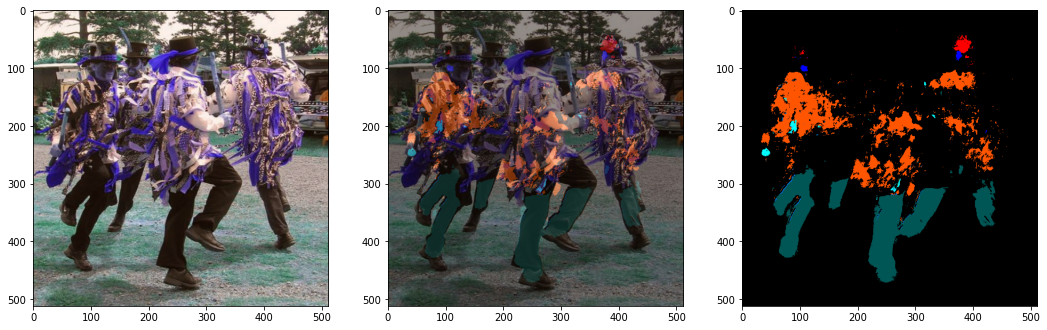

1/1 [==============================] - 0s 74ms/step


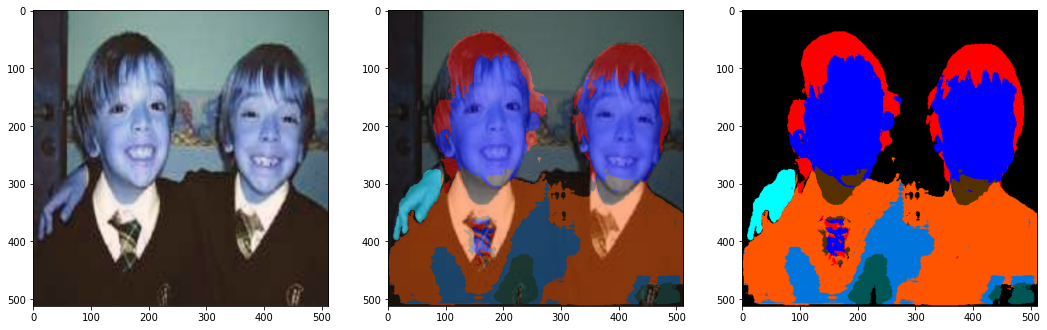

In [ ]:
plot_predictions(train_images[:4], colormap, model=model)

1/1 [==============================] - 0s 88ms/step


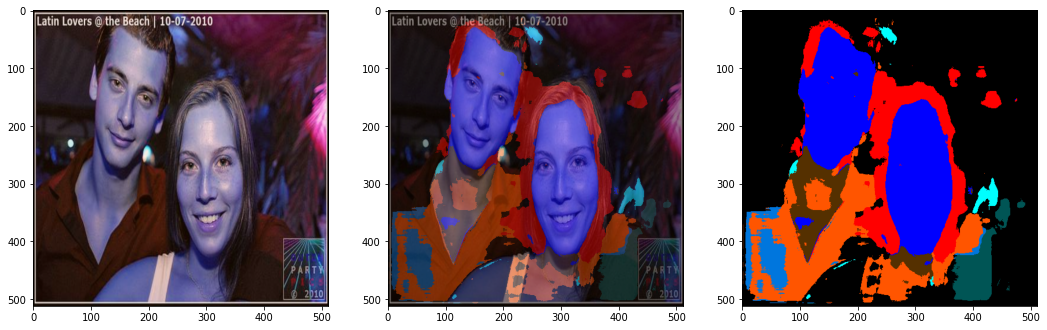

1/1 [==============================] - 0s 77ms/step


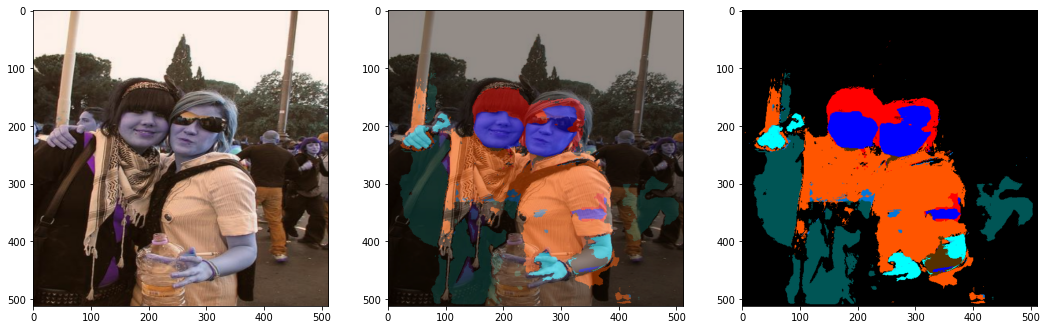

1/1 [==============================] - 0s 66ms/step


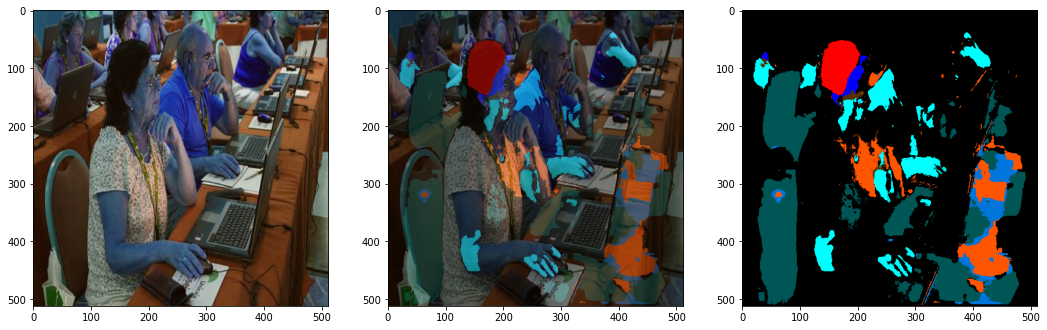

1/1 [==============================] - 0s 73ms/step


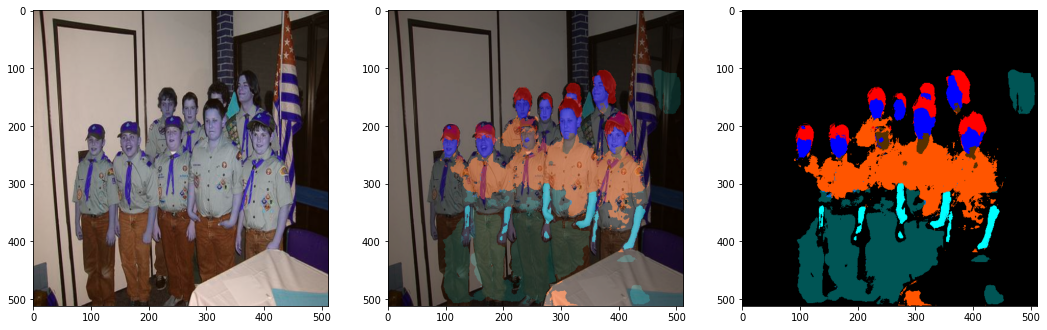

In [ ]:
plot_predictions(val_images[:4], colormap, model=model)

In [ ]:
model.save('semantic_segmentation_model.h5')

In [ ]:
!zip -r /content/file.zip /content/semantic_segmentation_model.h5

  adding: content/semantic_segmentation_model.h5 (deflated 9%)


In [ ]:
from google.colab import files 
files.download()

In [ ]:
from google.colab import files
files.download('semantic_segmentation_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>